### Datasette

Datasette is a sqlite visual explorer.  `make launch-simulator` should have already kicked off an instance running at [http://127.0.0.1:8001/](http://127.0.0.1:8001/).  

If not, you can run an instance from terminal with `datasette draft.db`

## Pandas

Here is some helper code for exploring the data with pandas

In [1]:
from blitz_env.simulate_draft_sqlite import init_database
from blitz_env.models import DatabaseManager
import pandas as pd

db = init_database(2025)
df = pd.read_sql("SELECT * FROM players", db.engine)
df

,id,full_name,professional_team,player_bye_week,rank,tier,position_rank,position_tier,gsis_id,allowed_positions,availability,pick_chosen,current_bot_id
0,19788,Ja'Marr Chase,CIN,10,1,1,1,1,00-0036900,"[""WR""]",AVAILABLE,None,None
1,23133,Bijan Robinson,ATL,5,2,1,1,1,00-0038542,"[""RB""]",AVAILABLE,None,None
2,19202,CeeDee Lamb,DAL,10,3,1,2,1,00-0036358,"[""WR""]",AVAILABLE,None,None
3,19236,Justin Jefferson,MIN,6,4,1,3,1,00-0036322,"[""WR""]",AVAILABLE,None,None
4,22968,Jahmyr Gibbs,DET,8,5,1,2,1,00-0039139,"[""RB""]",AVAILABLE,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,25334,Derius Davis,LAC,12,514,16,163,11,00-0038573,"[""WR""]",AVAILABLE,None,None
514,18714,Scotty Miller,PIT,5,515,16,173,11,00-0035298,"[""WR""]",AVAILABLE,None,None
515,23798,Hassan Haskins,LAC,12,516,16,129,10,00-0037617,"[""RB""]",AVAILABLE,None,None
516,16743,Johnny Mundt,JAC,8,517,16,63,8,00-0033246,"[""TE""]",AVAILABLE,None,None


## Example Draft

In [2]:
from blitz_env.simulate_draft_sqlite import simulate_draft, visualize_draft_board
from blitz_env.models import DatabaseManager, Player

def draft_player() -> str:
    db = DatabaseManager()
    try:
        # First, try to get the best available QB
        best_qb = db.session.query(Player).filter(
            Player.availability == 'AVAILABLE',
            Player.allowed_positions.contains("QB"),
        ).order_by(Player.rank).first()
        
        if best_qb:
            return best_qb.id
        
        # If no QBs available, get best overall player
        best_player = db.session.query(Player).filter(
            Player.availability == 'AVAILABLE'
        ).order_by(Player.rank).first()
        
        return best_player.id if best_player else ""
    finally:
        db.close()

# Run the draft simulation - data is stored in SQLite database
season = 2024
simulate_draft(draft_player, season)

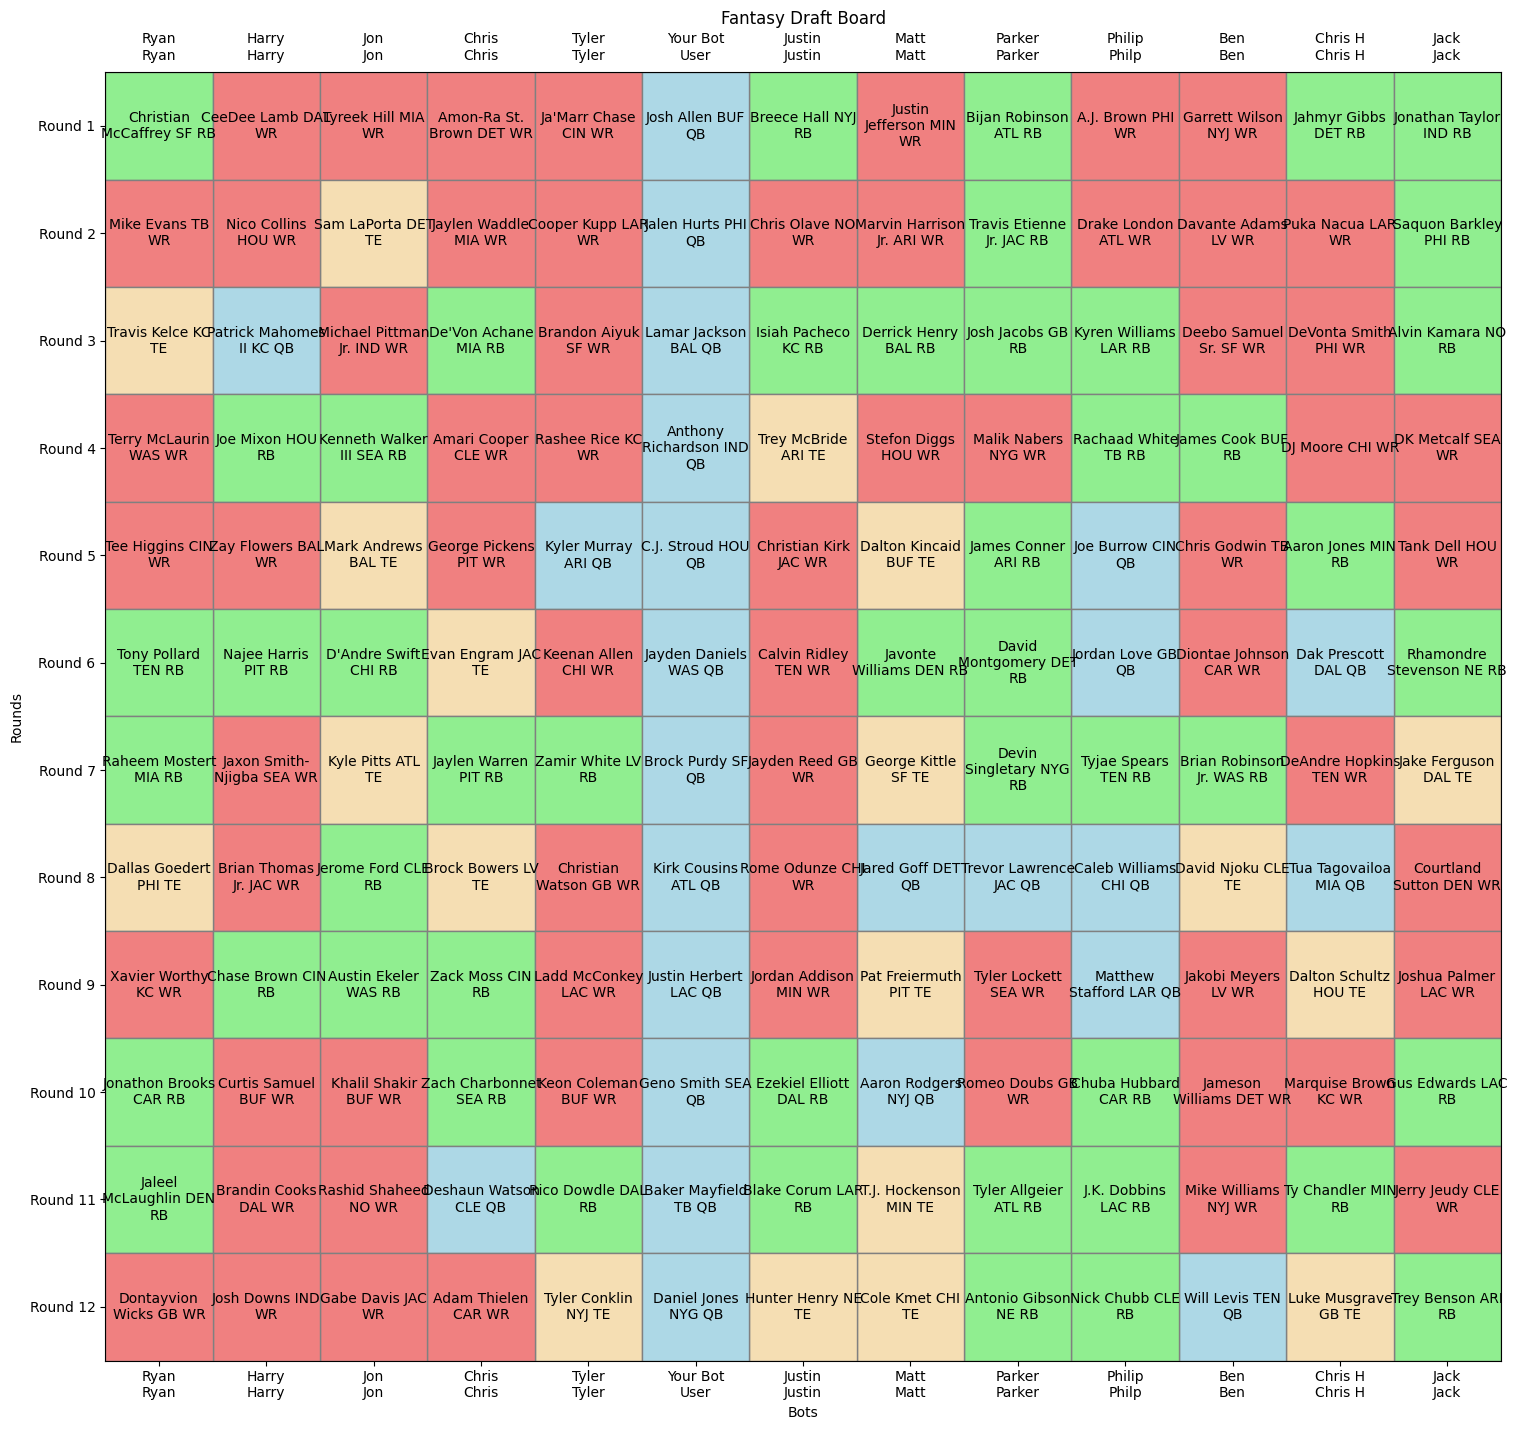

In [3]:
visualize_draft_board()

Downcasting floats.
[('Philp', 2087.3799998760223), ('Harry', 2079.5200033187866), ('Matt', 1900.5000095367432), ('Parker', 1756.119997009635), ('Jack', 1748.9000012874603), ('Ben', 1707.340006828308), ('Chris', 1702.4000041484833), ('Chris H', 1687.7999956905842), ('Tyler', 1687.2600039765239), ('Jon', 1479.2999942302704), ('Ryan', 1451.6999914646149), ('Justin', 1382.2000024318695), ('User', 1010.4999904632568)]


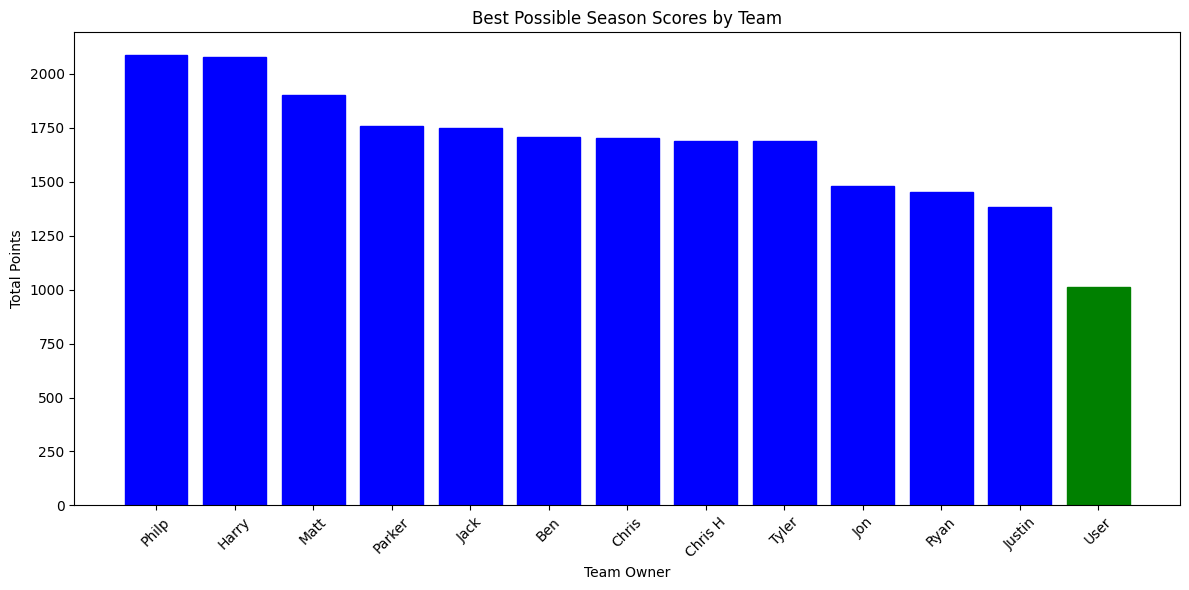

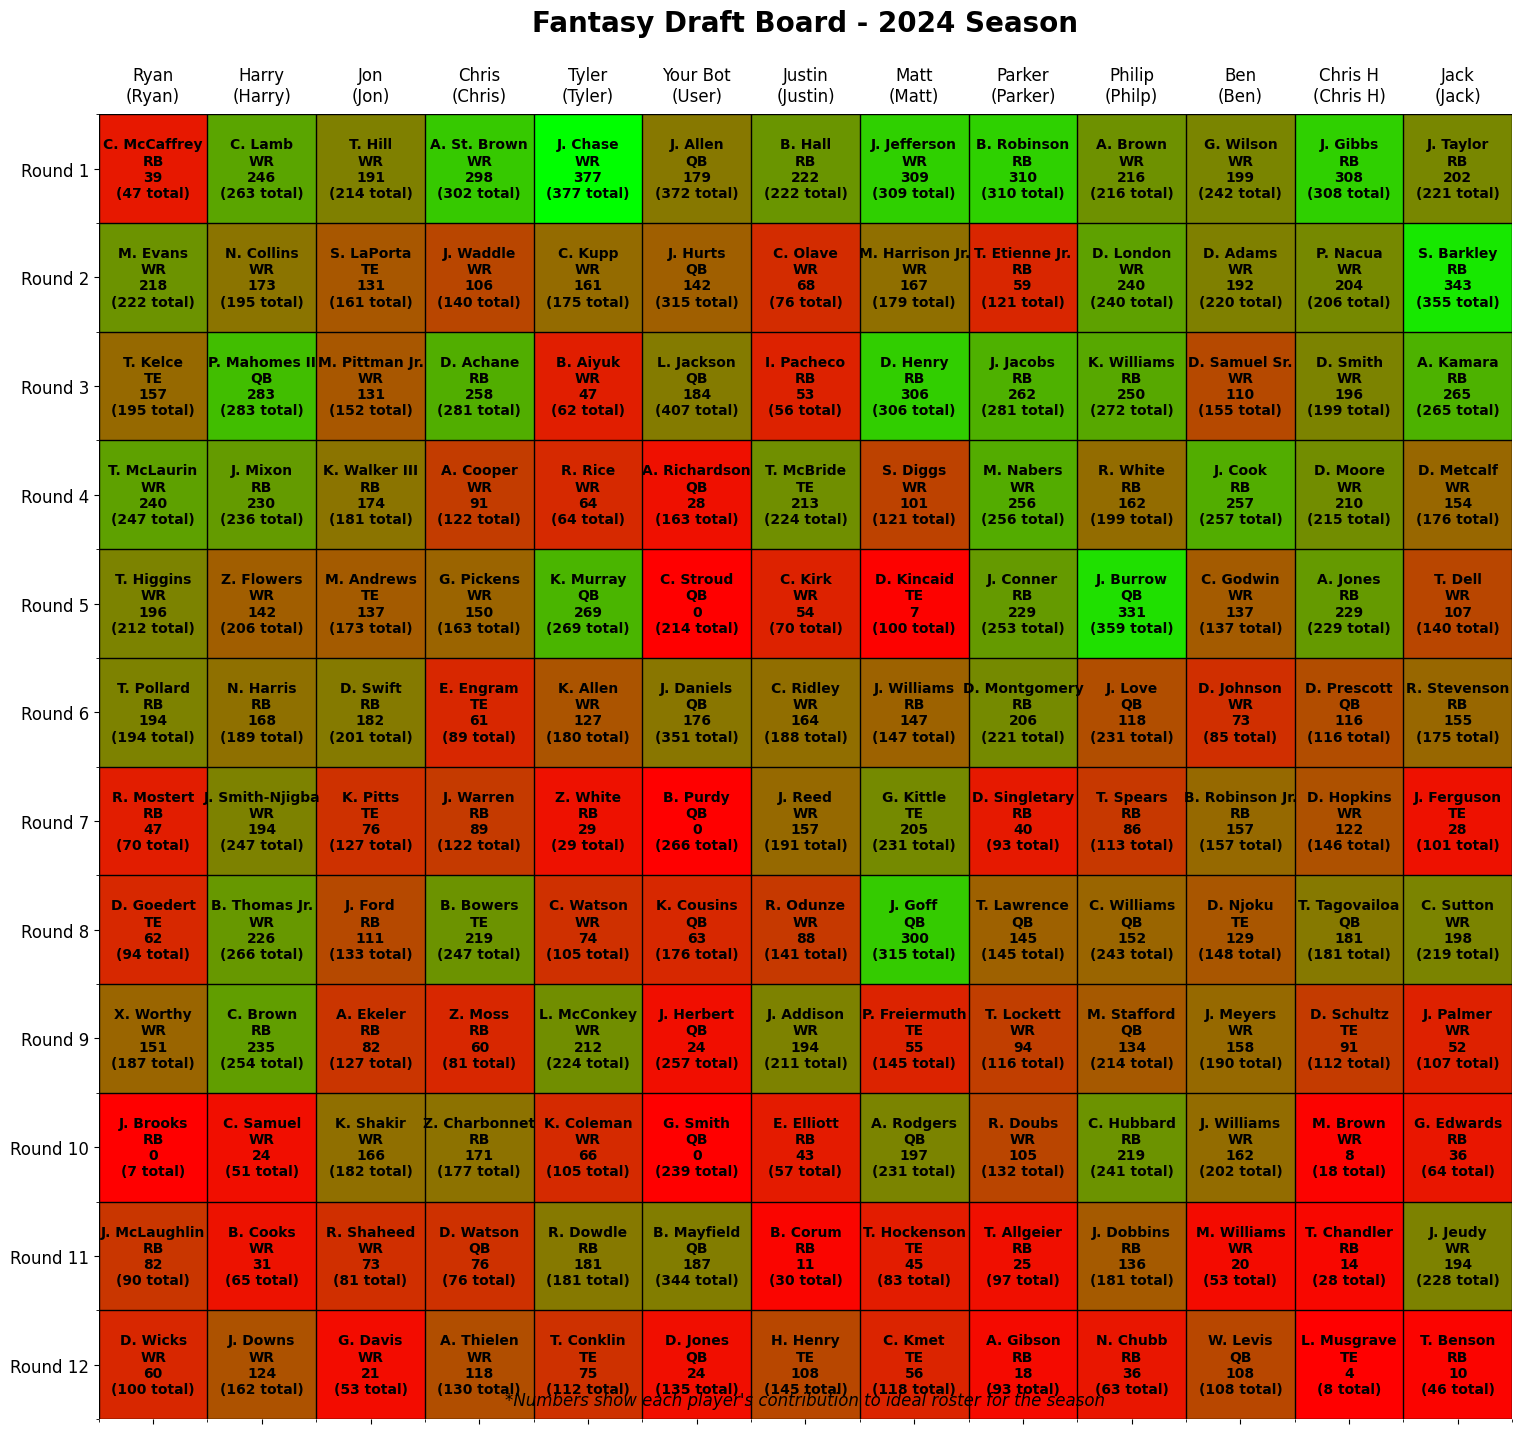

In [4]:
from blitz_env.score_game_sqlite import score_draft_for_visualization

if season < 2025:
    score_draft_for_visualization()